In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, to_date, split, when, coalesce
from pyspark.sql.types import MapType, StringType

In [2]:
spark = SparkSession.builder \
                    .appName('tennis') \
                    .getOrCreate()

# Singles

In [3]:
singles=spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')

singles.show(2)

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+--------------+-----------+---------+----------+----------+--------+----------+-----------+-------------+----------+--------+---------+---------+-----------+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|   winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|   loser_name|loser_hand|loser_ht|loser_ioc|loser_age|      score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+-

In [4]:
from pyspark.sql.functions import col, count, round

singles = singles.withColumn('winner_entry', when(singles['winner_entry'].isNull(), "Standard").otherwise(singles['winner_entry']))
singles = singles.withColumn('loser_entry', when(singles['loser_entry'].isNull(), "Standard").otherwise(singles['loser_entry']))

null_counts = singles.select([round(((count(when(col(c).isNull(), c)) / singles.count()) * 100), 1).alias(c) for c in singles.columns])
null_counts.show()

+----------+------------+-------+---------+-------------+------------+---------+---------+-----------+------------+-----------+-----------+---------+----------+----------+--------+----------+-----------+----------+----------+--------+---------+---------+-----+-------+-----+-------+-----+----+------+-------+--------+--------+-------+---------+---------+-----+----+------+-------+--------+--------+-------+---------+---------+-----------+------------------+----------+-----------------+
|tourney_id|tourney_name|surface|draw_size|tourney_level|tourney_date|match_num|winner_id|winner_seed|winner_entry|winner_name|winner_hand|winner_ht|winner_ioc|winner_age|loser_id|loser_seed|loser_entry|loser_name|loser_hand|loser_ht|loser_ioc|loser_age|score|best_of|round|minutes|w_ace|w_df|w_svpt|w_1stIn|w_1stWon|w_2ndWon|w_SvGms|w_bpSaved|w_bpFaced|l_ace|l_df|l_svpt|l_1stIn|l_1stWon|l_2ndWon|l_SvGms|l_bpSaved|l_bpFaced|winner_rank|winner_rank_points|loser_rank|loser_rank_points|
+----------+------------+-

In [6]:
selected_columns = ['surface',
                    'tourney_level',
                    'tourney_name',
                    'draw_size',
                    'winner_name',
                    'winner_hand', 
                    'winner_ht',
                    'winner_ioc',
                    'winner_age',
                    'loser_name',
                    'loser_hand',
                    'loser_ht',
                    'loser_ioc',
                    'winner_entry',
                    'loser_entry',
                    'loser_age',
                    'best_of',
                    'round',
                    'winner_rank',
                    'loser_rank'
                   ]

clean_df = singles.select(selected_columns)
clean_df = clean_df.filter(clean_df['best_of'] != 1)
clean_df = clean_df.dropna()
clean_df.show(2)

+-------+-------------+------------+---------+-------------+-----------+---------+----------+----------+-------------+----------+--------+---------+------------+-----------+---------+-------+-----+-----------+----------+
|surface|tourney_level|tourney_name|draw_size|  winner_name|winner_hand|winner_ht|winner_ioc|winner_age|   loser_name|loser_hand|loser_ht|loser_ioc|winner_entry|loser_entry|loser_age|best_of|round|winner_rank|loser_rank|
+-------+-------------+------------+---------+-------------+-----------+---------+----------+----------+-------------+----------+--------+---------+------------+-----------+---------+-------+-----+-----------+----------+
|   Hard|            A|    Adelaide|       32|Thomas Muster|          L|      180|       AUT|      26.2|Bryan Shelton|         R|     185|      USA|    Standard|   Standard|     28.0|      3|  R32|          9|        97|
|   Hard|            A|    Adelaide|       32| Brett Steven|          R|      185|       NZL|      24.6|  Byron Blac

In [7]:
clean_df.dtypes

[('surface', 'string'),
 ('tourney_level', 'string'),
 ('tourney_name', 'string'),
 ('draw_size', 'int'),
 ('winner_name', 'string'),
 ('winner_hand', 'string'),
 ('winner_ht', 'int'),
 ('winner_ioc', 'string'),
 ('winner_age', 'double'),
 ('loser_name', 'string'),
 ('loser_hand', 'string'),
 ('loser_ht', 'int'),
 ('loser_ioc', 'string'),
 ('winner_entry', 'string'),
 ('loser_entry', 'string'),
 ('loser_age', 'double'),
 ('best_of', 'int'),
 ('round', 'string'),
 ('winner_rank', 'int'),
 ('loser_rank', 'int')]

In [8]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
import scipy.stats as stats
import pandas as pd
from sklearn import preprocessing

df = clean_df.toPandas()
le = preprocessing.LabelEncoder()
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [ ]:
correlation_matrix_list = []

for a in clean_df.dtypes:
    print(a)
    correlation_list = []

    for b in clean_df.dtypes:
        #print(b)
        
        if a[1] == b[1] and a[1] == 'string':
            confusion_matrix = pd.crosstab(df[a[0]], df[b[0]])
            correlacao = cramers_v(confusion_matrix.values)
                            
        if a[1] == b[1] and a[1] == 'int':
            #features = [a[0], b[0]]  # List of column names
            correlacao = df[a[0]].corr(df[b[0]])

        if a[1] != b[1]:
            df[a[0]] = le.fit_transform(df[a[0]])
            df[b[0]]= le.fit_transform(df[b[0]])

            correlacao = stats.pointbiserialr(df[a[0]], df[b[0]])[0]
        
        correlation_list.append(correlacao)

    correlation_matrix_list.append(correlation_list)

('surface', 'string')
('tourney_level', 'string')
('tourney_name', 'string')
('draw_size', 'int')
('winner_name', 'string')
('winner_hand', 'string')
('winner_ht', 'int')
('winner_ioc', 'string')
('winner_age', 'double')
('loser_name', 'string')


We calculated diferent correlation tests depending on the varai

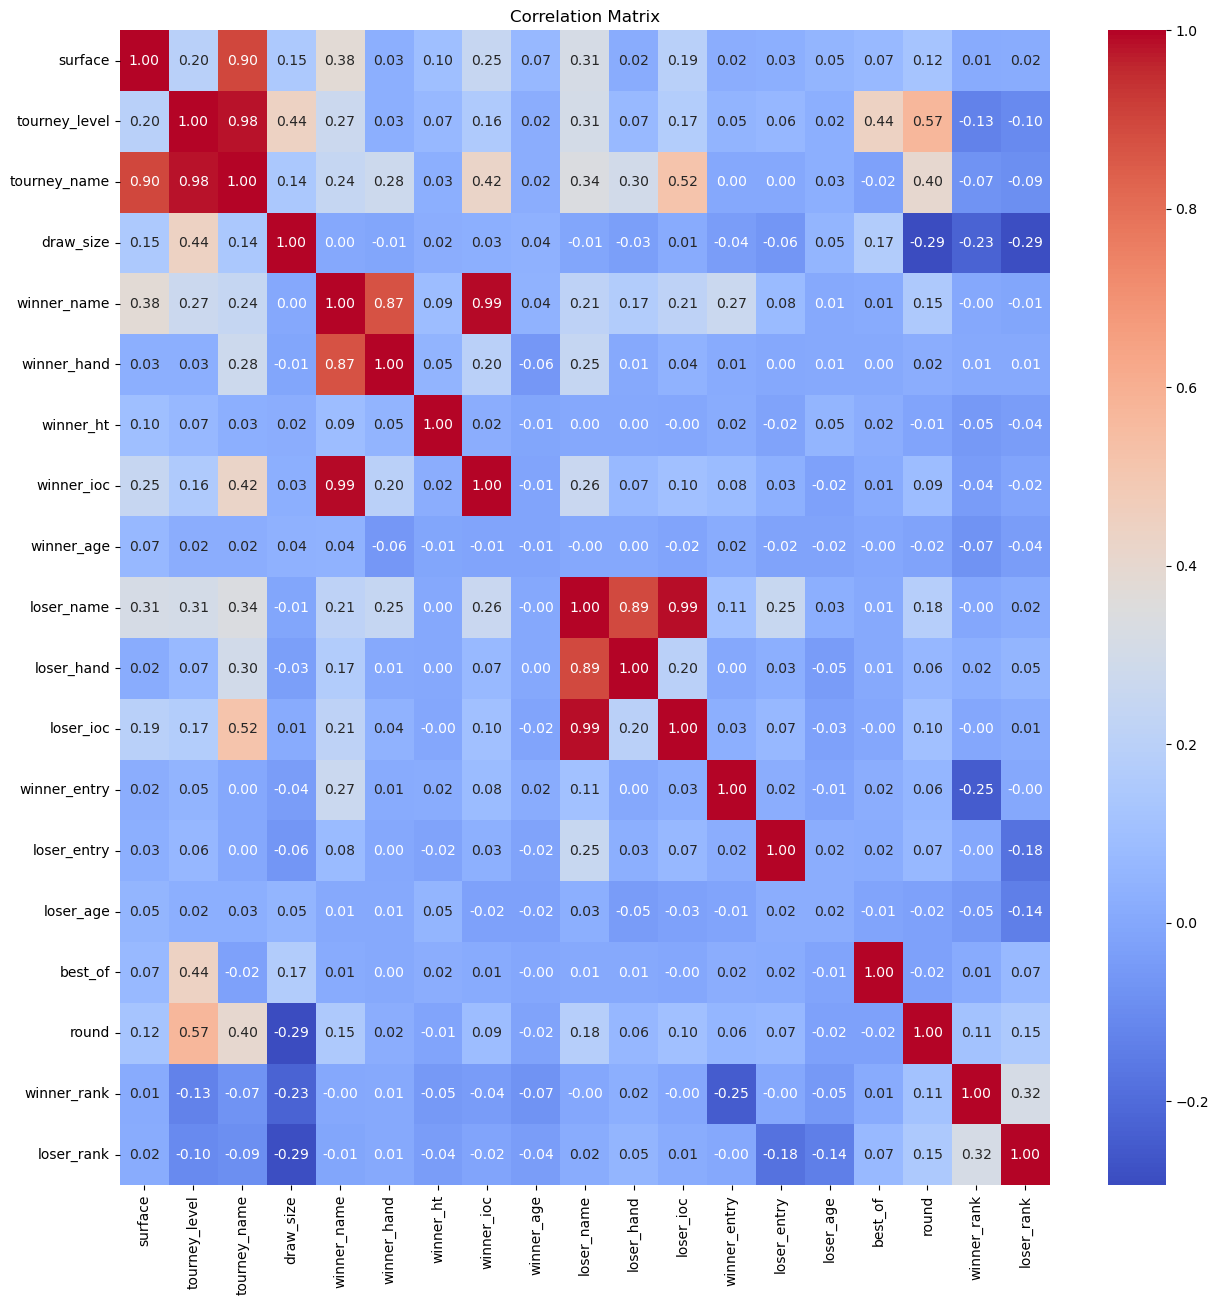

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

column_names = clean_df.columns

correlation_matrix_array = np.array(correlation_matrix_list)

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix_array, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=90)
plt.yticks(ticks=np.arange(len(column_names)) + 0.5, labels=column_names, rotation=0)
plt.show()

#matriz de correlação das variaveis para o modelo de ml